In [1]:
import pandas as pd
import numpy as np
import dask.dataframe as dd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing, metrics
from ipywidgets import widgets, interactive
import gc
import joblib
import glob
import os
import warnings
from datetime import datetime, timedelta
from typing import Union
from tqdm.notebook import tqdm_notebook as tqdm
from itertools import cycle
import datetime as dt
from torch.autograd import Variable
import random
from matplotlib.pyplot import figure
import torch
import torch.nn as nn
from copy import deepcopy
from torch.utils.data import Dataset
from sklearn.metrics import mean_squared_error



warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)


In [ ]:
from cnn_depthwise import cnnlstm


In [ ]:
# load dataset and show the first run
case1run1 = pd.read_csv('./mill_data/case1run1.csv')
case1run2 = pd.read_csv('./mill_data/case1run2.csv')
columns=['case', 'run', 'VB', 'time', 'doc','feed','material','smcAC', 'smcDC', 'vib_table', 'vib_spindle', 'AE_table', 'AE_spindle']
case1run1.columns = columns
case1run2.columns = columns

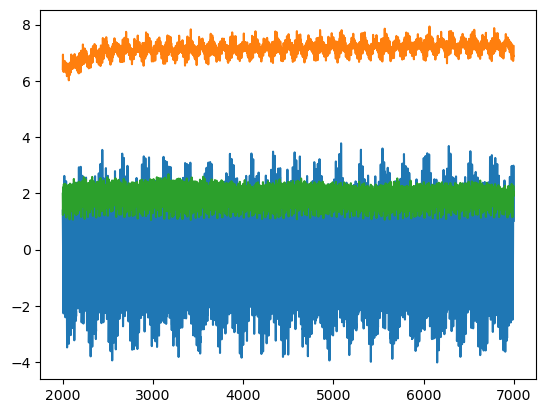

In [4]:
plt.plot(case1run2['smcAC'][2000:-2000])
plt.plot(case1run2['smcDC'][2000:-2000])
plt.plot(case1run2['vib_table'][2000:-2000])
plt.show()

In [6]:
case1run1_data = case1run1[columns]
print(case1run1_data.head(17))

    case  run  VB  time  doc  feed  material     smcAC     smcDC  vib_table  \
0      1    1   0     2  1.5   0.5         1  0.263672  0.810547   0.085449   
1      1    1   0     2  1.5   0.5         1  0.207520  0.781250   0.078125   
2      1    1   0     2  1.5   0.5         1  0.302734  0.849609   0.073242   
3      1    1   0     2  1.5   0.5         1  0.239258  1.098633   0.083008   
4      1    1   0     2  1.5   0.5         1  0.258789  1.225586   0.075684   
5      1    1   0     2  1.5   0.5         1  0.073242  1.152344   0.080566   
6      1    1   0     2  1.5   0.5         1  0.021973  1.123047   0.078125   
7      1    1   0     2  1.5   0.5         1 -0.141602  1.293945   0.085449   
8      1    1   0     2  1.5   0.5         1 -0.104980  1.411133   0.083008   
9      1    1   0     2  1.5   0.5         1 -0.461426  1.313477   0.073242   
10     1    1   0     2  1.5   0.5         1 -0.446777  1.210938   0.083008   
11     1    1   0     2  1.5   0.5         1 -0.6469

In [7]:
def sliding_windows(data):
    x = []
    for i in range(int((len(data)-512)/100)):
        _x = data[i*100:i*100+512]
        x.append(_x)
    x=np.array(x)
    return x

def labeling(data,lab):
    x = []
    for i in range(int((len(data)-512)/100)):
        _x = data[i*100:i*100+512]
        x.append(lab)

    return np.array(x)


def to_dataset(data,label):
    smcAC=np.expand_dims(sliding_windows(data['smcAC'][2000:-2000]),axis=2)
    smcDC=np.expand_dims(sliding_windows(data['smcDC'][2000:-2000]),axis=2)
    vib_table=np.expand_dims(sliding_windows(data['vib_table'][2000:-2000]),axis=2)
    vib_spindle=np.expand_dims(sliding_windows(data['vib_spindle'][2000:-2000]),axis=2)
    AE_table=np.expand_dims(sliding_windows(data['AE_table'][2000:-2000]),axis=2)
    AE_spindle=np.expand_dims(sliding_windows(data['AE_spindle'][2000:-2000]),axis=2)
    xdata = np.concatenate((smcAC,smcDC,vib_table,vib_spindle,AE_table,AE_spindle),axis=2)

    ydata = labeling(data[2000:-2000], label)
    return xdata,ydata

def to_casedataset(data_list):
    empty_x=np.zeros(((1, 512, 6)))
    empty_y=np.zeros(((1)))

    for i in data_list:
        pdd=pd.read_csv('./mill_data/'+i)
        pdd.columns = columns
        lab=pdd['VB'][0]
        if str(lab)!='nan':
            x_,y_=to_dataset(pdd,lab)
            empty_x=np.concatenate((empty_x,x_),axis=0)
            empty_y=np.concatenate((empty_y,y_),axis=0)
    empty_x=np.transpose(empty_x[1:],(0,2,1))

    return empty_x,empty_y[1:]

In [12]:
path = './mill_data/'
file_list = os.listdir(path)
case1list=[file for file in file_list if file.startswith('case1run')]
case9list=[file for file in file_list if file.startswith('case9run')]

c1_x,c1_y=to_casedataset(case1list)
c9_x,c9_y=to_casedataset(case9list)

In [21]:
class SequenceDataset(Dataset):
    def __init__(self, x, y):
        self.x=x
        self.y=y
        
    def __len__(self):
        return self.x.shape[0]

    def __getitem__(self, i): 
        data=self.x[i]
        label=self.y[i]

        return data,label

In [22]:
c1_x = Variable(torch.Tensor(np.array(c1_x)))
c1_y = Variable(torch.Tensor(np.array(c1_y)))
c9_x = Variable(torch.Tensor(np.array(c9_x)))
c9_y = Variable(torch.Tensor(np.array(c9_y)))


print("train shape is:",c1_x.size())
print("train label shape is:",c1_y.size())
print("test shape is:",c9_x.size())
print("test label shape is:",c9_y.size())

train shape is: torch.Size([572, 6, 512])
train label shape is: torch.Size([572])
test shape is: torch.Size([396, 6, 512])
test label shape is: torch.Size([396])


In [23]:
c1_dataset=SequenceDataset(c1_x,c1_y)
c9_dataset=SequenceDataset(c9_x,c9_y)

In [24]:
torch.manual_seed(99)

train_loader = DataLoader(c1_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(c9_dataset, batch_size=1, shuffle=False)


In [30]:
learning_rate = 5e-5
# num_hidden_units = 4
epochs = 30
model = cnnlstm()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [31]:

def train_model(data_loader, model, loss_function, optimizer):
    num_batches = len(data_loader)
    total_loss = 0
    model.train()

    for X, y in data_loader:
        output = model(X)
        loss = torch.sqrt(loss_function(output, y))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / num_batches
    return avg_loss

def test_model(data_loader, model, loss_function):

    num_batches = len(data_loader)
    total_loss = 0

    model.eval()
    with torch.no_grad():
        for X, y in data_loader:
            output = model(X)
            total_loss += torch.sqrt(loss_function(output, y)).item()

    avg_loss = total_loss / num_batches
    return avg_loss

In [32]:

print("Untrained test")
print(test_model(test_loader, model, loss_function))
best_fitness = -100000


Untrained test
0.46711857432518344


run: 0
train_loss: 0.21420063243971932
test_loss: 0.2852440167858143
run: 1
train_loss: 0.15361641926897895
test_loss: 0.2194589338067806
run: 2
train_loss: 0.14452425473266178
test_loss: 0.21138374958977554
run: 3
train_loss: 0.144149552202887
test_loss: 0.23230712006639953
run: 4
train_loss: 0.1427850644621584
test_loss: 0.21868856499592462
run: 5
train_loss: 0.14190490088529056
test_loss: 0.21684704165943344
run: 6
train_loss: 0.1445417089594735
test_loss: 0.2507342973140755
run: 7
train_loss: 0.1432908152540525
test_loss: 0.2349526161196256
run: 8
train_loss: 0.1410565988885032
test_loss: 0.2219509468460926
run: 9
train_loss: 0.14026201350821388
test_loss: 0.23164015654662642
run: 10
train_loss: 0.14075933686561054
test_loss: 0.23783513527325909
run: 11
train_loss: 0.1401322413649824
test_loss: 0.23615838384086435
run: 12
train_loss: 0.14008607632584041
test_loss: 0.2445728262566557
run: 13
train_loss: 0.14046820915407604
test_loss: 0.25328197857045165
run: 14
train_loss: 0.1401610

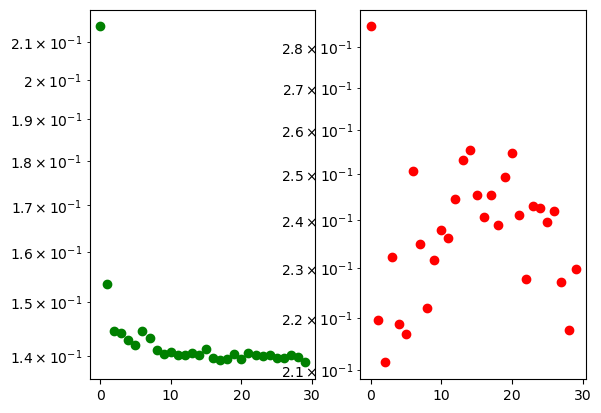

In [33]:
fig, axs = plt.subplots(1, 2)
for epoch in range(30):
    print("run:", epoch)
    train_loss = train_model(train_loader, model, loss_function, optimizer=optimizer)
    test_loss = test_model(test_loader, model, loss_function)
    print("train_loss:",train_loss)
    print("test_loss:",test_loss)
    axs[0].scatter(epoch, train_loss, color='g')
    axs[1].scatter(epoch, test_loss, color='r')
    fitness = -test_loss
    if fitness > best_fitness:
        best_fitness = fitness
        best_model = deepcopy(model)
axs[0].set_yscale('log')
axs[1].set_yscale('log')
plt.show()
plt.cla()
plt.clf()
plt.close()

In [34]:
def test_model2(data_loader, model, loss_function):

    num_batches = len(data_loader)
    total_loss = 0

    model.eval()
    a=[]
    b=[]
    with torch.no_grad():
        for X, y in data_loader:
            output = model(X)
            total_loss += torch.sqrt(loss_function(output, y)).item()
            a.append(y)
            b.append(output)

    avg_loss = total_loss / num_batches
    return avg_loss,a,b

In [35]:
test_loader = DataLoader(c9_dataset, batch_size=int(len(c9_dataset)/13), shuffle=False)
print('Predictions on test set')

Predictions on test set


In [36]:
c,v,n=test_model2(test_loader, model, loss_function)

In [37]:
q,w=[],[]
for i in range(len(v)):
    q.append(sum(v[i])/len(v[i]))
    w.append(sum(n[i])/len(n[i]))

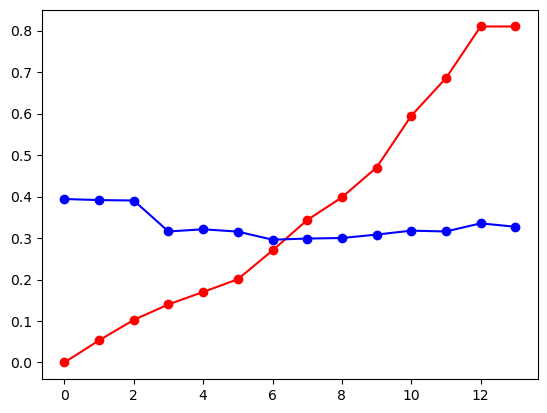

In [38]:
plt.plot(q, 'bo-',color='r')
plt.plot(w, 'bo-',color='b')

In [39]:
train_loader = DataLoader(c1_dataset, batch_size=int(len(c1_dataset)/13), shuffle=False)
print('Predictions on train set')

Predictions on train set


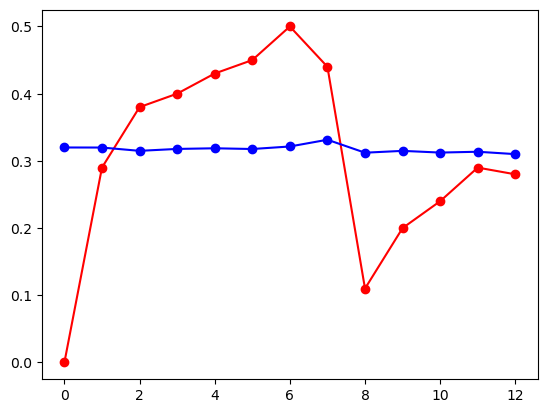

In [40]:
c,v,n=test_model2(train_loader, model, loss_function)
q,w=[],[]
for i in range(len(v)):
    q.append(sum(v[i])/len(v[i]))
    w.append(sum(n[i])/len(n[i]))
    
plt.plot(q, 'bo-',color='r')
plt.plot(w, 'bo-',color='b')